#### Transferlearning:  
Transferlearning innebär att man använder ett redan tränat neuralt nätverk men adderar i slutet en egen classification del. Fördelen är att man inte tränar det neurala nätverket, vilket sparar mycket tid och beräkningsresurser.  
Transferlearning är också fördelaktigt om man har ett begränsat eget dataset (om man tränar ett nätverk from scratch med ett litet dataset finns stor risk för overfit).  
Finetuning: närbesläktad teknik, men den innebär att man dessutom tränar om delar av det neurala nätverket.  
I transferlearning kan man göra "domain adaptation", dvs man har en grundmodell med generell kunskap (teg ImageNet), som sedan tränas för ett specifikt område, tex medicinsk diagnos.
Måste installera nedan för att få tillgång till datasetet:  
`pip install tensorflow_datasets`

Load dataset, split into train and test sets. Return the data in a supervised format and with additional information.  
Supervised format = tuple med (image, label)

In [14]:
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
(train, test), info = tfds.load('tf_flowers',
                                split=['train[:80%]', 'train[80%:]'],
                                with_info=True,
                                as_supervised=True)
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\danie\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

Kollar vilka label namn som finns i datasetet.

In [4]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

img_shape: (333, 500, 3), label: 2
img_shape: (212, 320, 3), label: 3
img_shape: (240, 320, 3), label: 3
img_shape: (240, 320, 3), label: 4
img_shape: (317, 500, 3), label: 3
img_shape: (212, 320, 3), label: 0
img_shape: (240, 240, 3), label: 0
img_shape: (333, 500, 3), label: 0


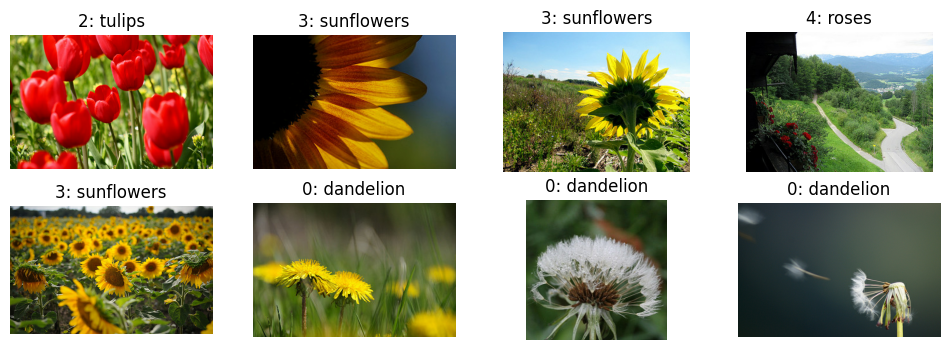

In [9]:
label_names = info.features['label'].names
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
for i, img_sample in enumerate(train.take(8)):
    print(f"img_shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i] # axes[i // 4, i % 4]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis('off')

Definierar en funktion som:
- resize'ar bilden till 120x120 pixlar
- normaliserar pixel values till range [0, 1] genom att dividera med 255.0
- returnerar en processad bild tillsammans med dess label
- `prefetch(1)` används som ett sätt att multitaska, den kan förbereda en batch samtidigt som en batch tränas, typ...

In [ ]:
import tensorflow as tf

def preprocess(image, label, img_shape=(120, 120)):
    """preprocess function for the flowers dataset"""
    image = tf.image.resize(image, img_shape) / 255.0
    return image, label

input_shape = (120, 120, 3)
batch_size = 32

# shuffles the training dataset and preprocesses the images
# prefetch(1) allows the input pipeline to asynchronously fetch batches while the model is training
train_batch = train.shuffle(buffer_size=600).map(preprocess).batch(batch_size).prefetch(1)
test_batch = test.map(preprocess).batch(batch_size).prefetch(1)

Importerar en redan tränad modell som heter Xception.  
  
Xception står för "Extreme inception" och är en "deep cpnvolutional neural network architecture", känd för att efficiency och high performance map image classification.  
Modellen är del av keras.applications modulen, som innehåller fleratalet pre-trained modeller.  
  
`weights='imagenet'`betyder att man laddar de pre-trained vikterna på Xception modellen, som tränats på "imagenet" datasetet.  
  
`include_top = False` innebär att det "fully connected layers" inte ska vara med, dvs man endast har med det neurala nätverket. Det gör man eftersom dessa lager är specifika för imagenet klassificerings uppgifter. Genom att exkludera detta / dessa lager kan vi sedan addera ett eget lager som är specifikt för vår egna uppgift.

In [12]:
from keras.applications import Xception

feature_extractor = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Bygger ihop det totala nätverket:

In [ ]:
from keras import layers
from keras import models

model = keras.Sequential([
    feature_extractor,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),    
    layers.Dense(5, activation='softmax')
])

# freeze the feature extractor layers
for layer in feature_extractor.layers:
    layer.trainable = False 

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,175,789 (84.59 MB)

 Trainable params: 1,314,309 (5.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
model.fit(train_batch, epochs=20, validation_data=test_batch)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.4559 - loss: 1.5549 - val_accuracy: 0.7643 - val_loss: 0.6646
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6924 - loss: 0.8398 - val_accuracy: 0.8011 - val_loss: 0.5480
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7517 - loss: 0.6818 - val_accuracy: 0.8120 - val_loss: 0.5124
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7733 - loss: 0.6369 - val_accuracy: 0.8188 - val_loss: 0.5294
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7858 - loss: 0.5908 - val_accuracy: 0.8297 - val_loss: 0.4849
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8019 - loss: 0.5141 - val_accuracy: 0.8379 - val_loss: 0.4754
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8244 - loss: 0.5016 - val_accuracy: 0.8392 - val_loss: 0.4664
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8361 - loss: 0.4635 - val_accuracy: 0.8229 - v

#### Plottar med hjälp av Pandas
`metrics = pd.DataFrame(model.history.history)` skapar en Pandas DataFrame av model.history.history-objektet.  
  
`metrics[['loss', 'val_loss']].plot()` plottar kolumnerna som är angivna mha Pandas .plot() funktion

<Axes: >

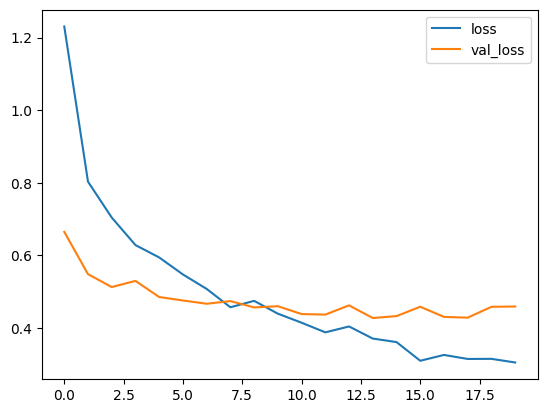

In [19]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)
metrics[['loss', 'val_loss']].plot()

<Axes: >

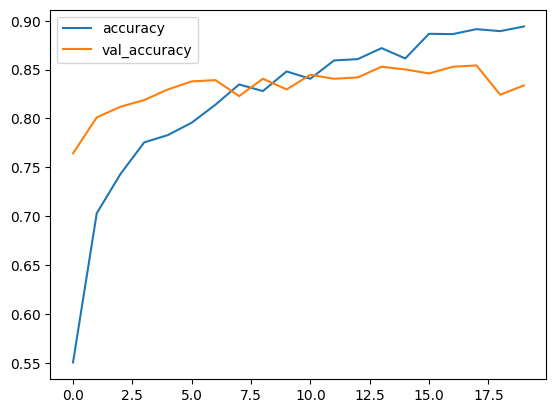

In [20]:
metrics[['accuracy', 'val_accuracy']].plot()